In [7]:
## mcl1.ipynb, mcl3.ipynb

In [1]:
import sys                       
sys.path.append('../script/')
from robot import *
from scipy.stats import multivariate_normal
import random #追加
import copy

In [2]:
class Particle:
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight
        
    def motion_update(self, time, nu, omega, noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        noised_nu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        noised_omega = omega + ns[2]*math.sqrt(abs(nu)/time) +ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(noised_nu, noised_omega, time, self.pose)
        
    def observation_update(self, observation, envmap, distance_dev_rate, direction_dev): 
        #print(observation)
        for d in observation:
            obs_pos = d[0]
            obs_id = d[1]
           
            pos_on_map = envmap.landmarks[obs_id].pos
            particle_suggest_pos = IdealCamera.observation_function(self.pose, pos_on_map)
            
            ### 尤度の計算 ###
            distance_dev = distance_dev_rate*particle_suggest_pos[0]
            cov = np.diag(np.array([distance_dev**2, direction_dev**2]))
            self.weight *= multivariate_normal(mean=particle_suggest_pos, cov=cov).pdf(obs_pos)
            

In [3]:
class Mcl:  ###Mcl3 (1,2,5行目以降を記載)
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                distance_dev_rate=0.14, direction_dev=0.05):
        self.particles = [Particle(init_pose, 1.0/num) for i in range(num)]
        self.map = envmap
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2]) # 雑音
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
    def motion_update(self, time, nu, omega):
        for p in self.particles: p.motion_update(time, nu, omega, self.motion_noise_rate_pdf)
            
    def observation_update(self, observation):   #メソッド追加
        for p in self.particles: p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev)
            
        #self.simple_resampling() #追加
        #self.systematic_resampling() #追加
        
    def simple_resampling(self):
        ws = [e.weight for e in self.particles]
        if sum(ws) < 1e-100: ws = [e + 1e-100 for e in ws]
        ps = random.choices(self.particles, weights=ws, k=len(self.particles))
        self.particles = [copy.deepcopy(e) for e in ps]
        for p in self.particles:p.weight = 1.0/len(self.particles) #重みの正規化
            
    def systematic_resampling(self):
        ws = np.cumsum([e.weight for e in self.particles])
        if ws[-1] < 1e-100: ws = [e + 1e-100 for e in ws]
            
        step = ws[-1]/len(self.particles)
        r = np.random.uniform(0.0, step)
        cur_pos = 0
        ps = []
        
        while(len(ps) < len(self.particles)):
            if r < ws[cur_pos]:
                ps.append(self.particles[cur_pos])
                r += step
            else:
                cur_pos += 1
            
        self.particles = [copy.deepcopy(e) for e in ps]
        for p in self.particles:p.weight = 1.0/len(self.particles) #重みの正規化
        
    def draw(self, ax, elems):   #追加
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2])*p.weight*len(self.particles) for p in self.particles] 
        vys = [math.sin(p.pose[2])*p.weight*len(self.particles) for p in self.particles] 
        elems.append(ax.quiver(xs, ys, vxs, vys, \
                               angles='xy', scale_units='xy', scale=1.5, color="blue", alpha=0.2))

In [4]:
class EstimationAgent(Agent):  ###EstimationAgent3 (1,2,6,7行目を記載)
    def __init__(self, time_interval, nu, omega, estimator): 
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self, observation=None):
        #self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.estimator.motion_update(self.time_interval, self.prev_nu, self.prev_omega)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.estimator.observation_update(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems):   #追加
        self.estimator.draw(ax, elems)

<IPython.core.display.Javascript object>


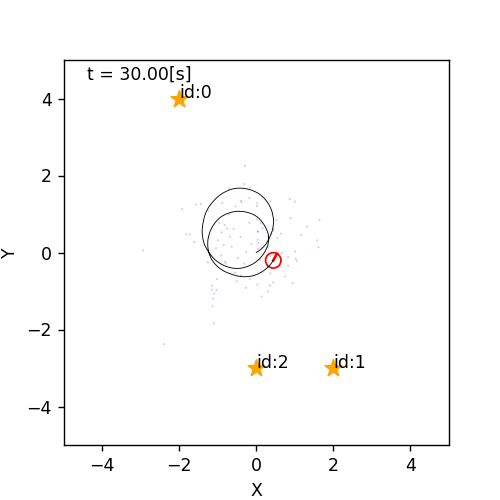

In [5]:
#def trial(motion_noise_stds):
def trial():
    time_interval=0.1
    world = World(30, time_interval, debug=False)
    
    ## landmark
    m = Map()
    for ln in [(-2,4), (2,-3), (0,-3)]: m.append_landmark(Landmark(*ln))
    world.append(m)
    
    ## robot
    initial_pose = np.array([0, 0, math.pi/6]).T
    #estimator = Mcl(m, initial_pose, 100, motion_noise_stds) # m:Map
    estimator = Mcl(m, initial_pose, 100) # m:Map
    circling = EstimationAgent(time_interval, 0.2, 12.0/180*math.pi, estimator)
    r = Robot(initial_pose, sensor=Camera(m), agent=circling, color="red")
    world.append(r)
    
    world.draw()
    world.ani.save('animation1_retry.mp4')

trial()
#trial({"nn":0.01, "no":0.02, "on":0.03, "oo":0.04})
    

In [2]:
import sys  ###sensor_experiment
sys.path.append('../script/')
from robot import *

m = Map()
m.append_landmark(Landmark(1,0))
distance = []
direction = []

for i in range(1000):
    c = Camera(m)    #バイアスの影響も考慮するため毎回カメラを新規作成
    d = c.data(np.array([0.0, 0.0, 0.0]).T)
    if len(d) > 0:
        distance.append(d[0][0][0])
        direction.append(d[0][0][1])

# 結果を表示
print(f"データ数: {len(distance)}")
print(f"\n{'Index':<8}{'Distance':<15}{'Direction':<15}")
print("-" * 38)

# 最初の10件を表示
for i in range(min(10, len(distance))):
    print(f"{i:<8}{distance[i]:<15.6f}{direction[i]:<15.6f}")

if len(distance) > 10:
    print("...")
    print(f"(残り {len(distance) - 10} 件)")

# 統計情報
print(f"\n--- 統計情報 ---")
print(f"Distance - 平均: {np.mean(distance):.6f}, 標準偏差: {np.std(distance):.6f}")
print(f"Direction - 平均: {np.mean(direction):.6f}, 標準偏差: {np.std(direction):.6f}")

データ数: 909

Index   Distance       Direction      
--------------------------------------
0       1.270885       0.081675       
1       0.762614       -0.002179      
2       0.827122       -0.047495      
3       1.188285       -0.056107      
4       1.058149       0.077573       
5       0.982122       0.083215       
6       1.051010       0.031623       
7       0.921861       0.110429       
8       0.937079       -0.029377      
9       0.901206       -0.024185      
...
(残り 899 件)

--- 統計情報 ---
Distance - 平均: 0.998613, 標準偏差: 0.144039
Direction - 平均: 0.000483, 標準偏差: 0.048140
